# Setup

In [1]:
# !pip install torchinfo
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split,Dataset,Subset
from torchinfo import summary
from tqdm import tqdm
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

/home/itlab/anaconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Create Resnet structure

In [3]:
# get BasicBlock which layers < 50(18, 34)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample #Residual Block結構的輸入與輸出通道數量不一致，這時候我們就需要在短路連接的時候調整通道數量

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [4]:
# get BottleBlock which layers >= 50
class Bottleneck(nn.Module):
    expansion = 4 # the factor of the last layer of BottleBlock and the first layer of it

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*4)
        self.downsample = downsample
        self.relu = nn.ReLU()


    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channel = 64

        self.conv1 = nn.Conv2d(1, self.in_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):

        # Initial convolution and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # First set of ResNet blocks
        feature1 = self.layer1(x)

        # Second set of ResNet blocks
        feature2 = self.layer2(feature1)

        # Third set of ResNet blocks
        feature3 = self.layer3(feature2)

        # Fourth set of ResNet blocks
        feature4 = self.layer4(feature3)

        # Global Average Pooling
        out = self.avgpool(feature4)
        out = out.view(out.size(0), -1) # Flatten the tensor

        # Fully connected layer for classification
        out = self.fc(out)

        return out, [feature1, feature2, feature3, feature4]

def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

def resnet101(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)

def resnet152(num_classes=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

# Teacher model

## Get pre-trained model

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# # unzip the model
# from zipfile import ZipFile

# #run this cell extract_tar.gz files

# with ZipFile('/content/drive/MyDrive/EAI-Project/utk_teacher_model.zip', 'r') as myzip:
#     myzip.extractall()
#     print('Done')

## Load model

In [8]:
Teacher = resnet34(num_classes=7)  # commment out this line if loading trained teacher model
state_dict = torch.load('../weights/utk_teacher_model.pth', map_location ='cpu')  # loading trained teacher model

Teacher.load_state_dict(state_dict)
Teacher = Teacher.to(device)

In [9]:
# summary(Teacher)

In [10]:
# Teacher.eval()

# Face Detection Model (MTCNN)

In [11]:
# !pip install torch torchvision facenet-pytorch

## Setup for test

In [12]:
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
import torch
from torch.utils.data import DataLoader
from collections import Counter

In [13]:
# MTCNN for face detection
mtcnn = MTCNN(keep_all=True, device='cuda')

# Transformation as used in your training, now including a grayscale conversion
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # or any other size used during training
    transforms.Grayscale(),  # Convert the image to grayscale
    transforms.ToTensor(),
])

# Define age ranges based on your training data
age_ranges = ["1-2", "3-9", "10-20", "21-27", "28-45", "46-65", "66-116"]

In [14]:
def display_image_with_ages(original_image, boxes, age_estimates):
    plt.imshow(np.array(original_image))
    ax = plt.gca()

    for box, age in zip(boxes, age_estimates):
        ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red', linewidth=1))
        plt.text(box[0], box[1], age, color='white', fontsize=10, backgroundcolor='red')

    plt.axis('off')
    plt.show()
    print("\n\n")

In [15]:
def show_ad(most_age):

  if(most_age == '3-9'):
    return "ad_0"
  elif(most_age == '10-20'):
    return "ad_1"
  elif(most_age == '10-20'):
    return "ad_2"
  elif(most_age == '21-27'):
    return "ad_3"
  elif(most_age == '28-45'):
    return "ad_4"
  elif(most_age == '46-65'):
    return "ad_5"
  elif(most_age == '66-116'):
    return "ad_6"
  else:
    return "No people, save the power"

In [16]:
def predict_ages(image_path):
    # Load and process the image
    img = Image.open(image_path)
    boxes, _ = mtcnn.detect(img)

    if boxes is not None:
        age_estimates = []

        # Initialize a counter for each age range
        age_range_count = Counter({age_range: 0 for age_range in age_ranges})

        draw = ImageDraw.Draw(img)

        for box in boxes:
            # Crop each face and apply the transformation
            face = img.crop(box)
            face = transform(face).unsqueeze(0).to(device)  # Add batch dimension and move to the device

            with torch.no_grad():
                # Get the output from the model
                output = Teacher(face)

                # If the output is a tuple, extract the tensor containing the age predictions
                if isinstance(output, tuple):
                    output = output[0]  # Assuming the first element of the tuple is the desired output

                predicted_age_range_idx = torch.argmax(output, dim=1).item()  # Get the predicted age range index
                predicted_age_range = age_ranges[predicted_age_range_idx]
                age_estimates.append(predicted_age_range)

                # Increment the count for the predicted age range
                age_range_count[predicted_age_range] += 1

            # Draw bounding box
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        # print("Got ages:" + str(age_estimates))
        print(str(age_range_count)+ "\n")

        # Calculate how many people in various age range
        most_common_ages = age_range_count.most_common(2)

        print("The most numerous range:", most_common_ages[0])
        # if use "most_common_ages[0][0]", we can get "the age range" of most people
        # print("The next most numerous range:", most_common_ages[1] if len(most_common_ages) > 1 else "None")

        ad = show_ad(most_common_ages[0][0])
        print(ad + " for the people whose age in " + str(most_common_ages[0][0]))

        # Display the results
        display_image_with_ages(img, boxes, age_estimates)

    else:

        plt.imshow(np.array(img))
        ax = plt.gca()

        plt.text(150,150,'No faces detected', color='white', fontsize=12, backgroundcolor='red')
        plt.axis('off')
        plt.show()
        print("\n\n")

# Test our flow with images

In [21]:
import os

file_list = []
for root, dirs, files in os.walk("../test_pics"):
    for file in files:
        file_list.append(file)

In [22]:
path = "../test_pics"
os.chdir(path)

Counter({'28-45': 2, '46-65': 1, '1-2': 0, '3-9': 0, '10-20': 0, '21-27': 0, '66-116': 0})

The most numerous range: ('28-45', 2)
ad_4 for the people whose age in 28-45


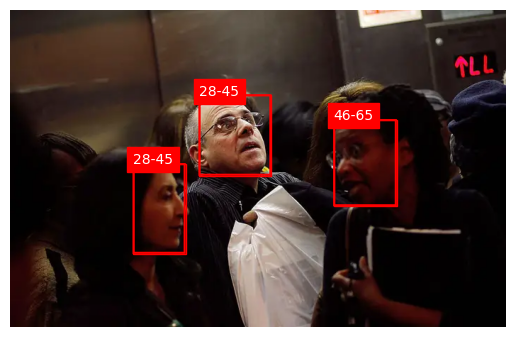




Counter({'28-45': 9, '21-27': 2, '46-65': 1, '1-2': 0, '3-9': 0, '10-20': 0, '66-116': 0})

The most numerous range: ('28-45', 9)
ad_4 for the people whose age in 28-45


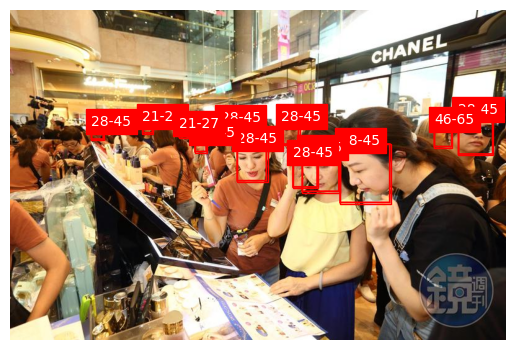

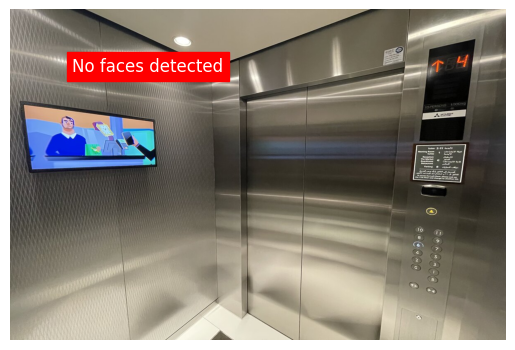




Counter({'21-27': 3, '28-45': 1, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('21-27', 3)
ad_3 for the people whose age in 21-27


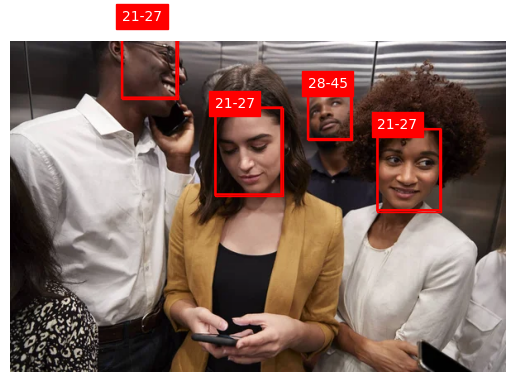




Counter({'28-45': 4, '21-27': 1, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 4)
ad_4 for the people whose age in 28-45


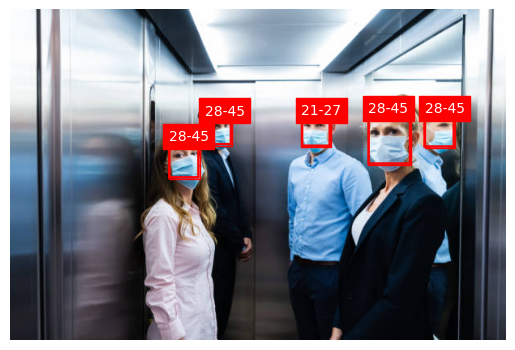




Counter({'28-45': 2, '21-27': 1, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 2)
ad_4 for the people whose age in 28-45


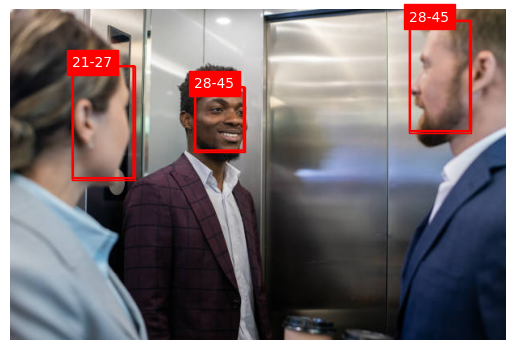




Counter({'28-45': 8, '21-27': 3, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 8)
ad_4 for the people whose age in 28-45


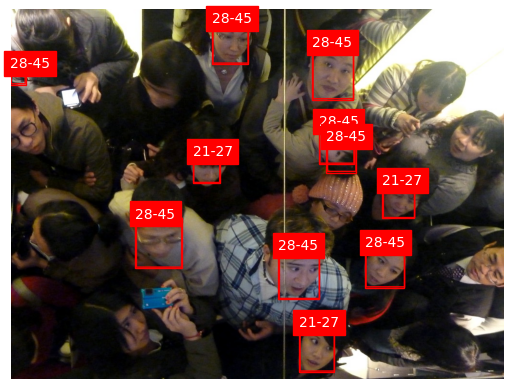




Counter({'28-45': 4, '21-27': 1, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 4)
ad_4 for the people whose age in 28-45


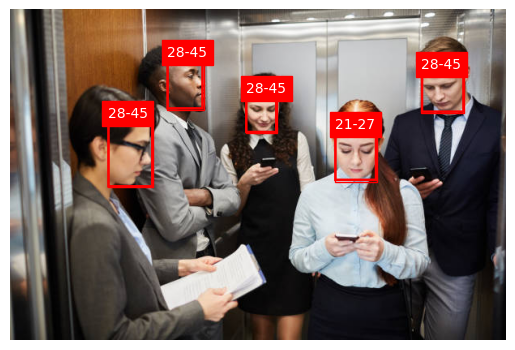




Counter({'10-20': 2, '28-45': 2, '1-2': 0, '3-9': 0, '21-27': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('10-20', 2)
ad_1 for the people whose age in 10-20


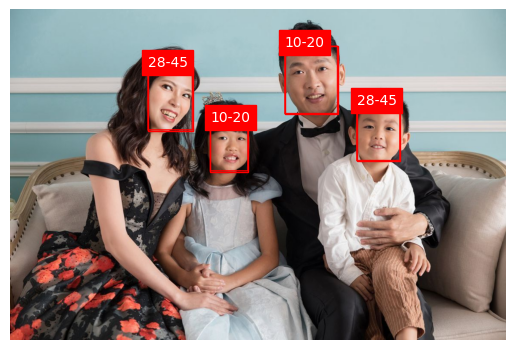

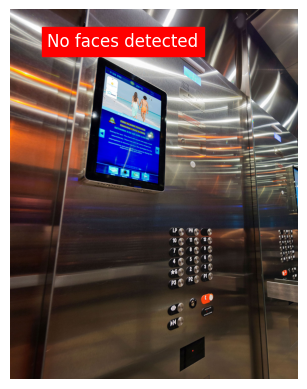




Counter({'28-45': 2, '1-2': 0, '3-9': 0, '10-20': 0, '21-27': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 2)
ad_4 for the people whose age in 28-45


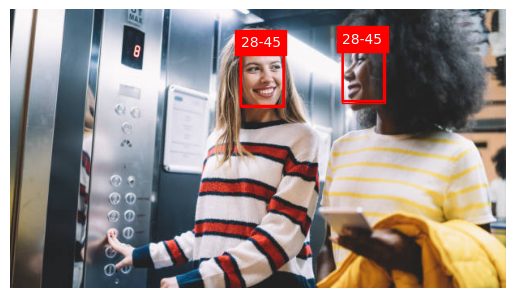




Counter({'28-45': 2, '21-27': 1, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 2)
ad_4 for the people whose age in 28-45


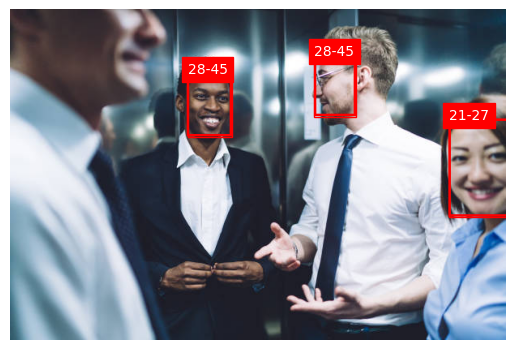




Counter({'28-45': 3, '46-65': 1, '1-2': 0, '3-9': 0, '10-20': 0, '21-27': 0, '66-116': 0})

The most numerous range: ('28-45', 3)
ad_4 for the people whose age in 28-45


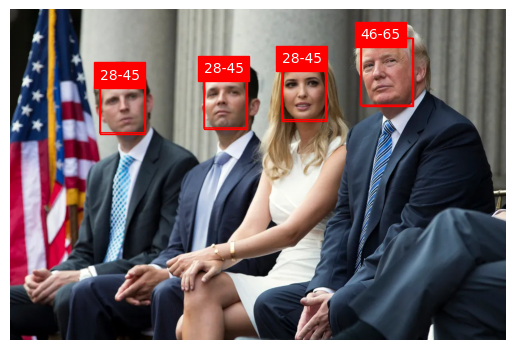

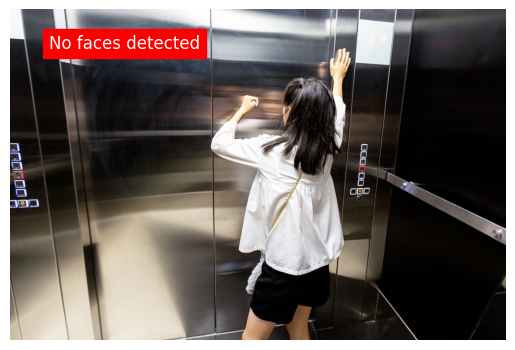




Counter({'28-45': 8, '1-2': 0, '3-9': 0, '10-20': 0, '21-27': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('28-45', 8)
ad_4 for the people whose age in 28-45


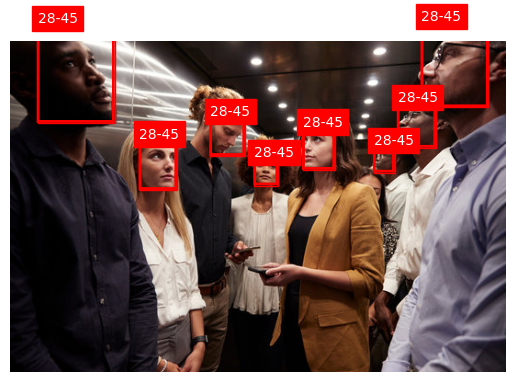




Counter({'21-27': 3, '28-45': 3, '1-2': 0, '3-9': 0, '10-20': 0, '46-65': 0, '66-116': 0})

The most numerous range: ('21-27', 3)
ad_3 for the people whose age in 21-27


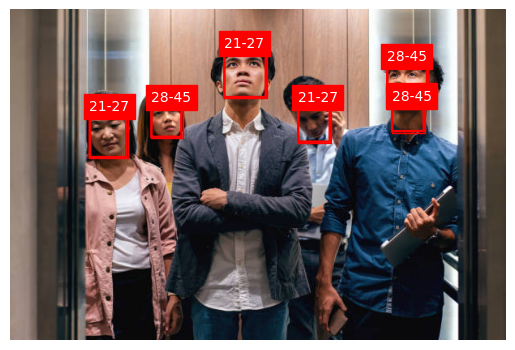

In [23]:

for i in file_list:
  predict_ages(i)